In [185]:
#!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.3 MB/s eta 0:00:00


In [121]:
%load_ext autoreload

In [122]:
%autoreload 2
import random
import itertools
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import graphviz
from collections import defaultdict
from better_draw_class import *

In [43]:
class Expression:
    def __init__(self,left,right=None):
        if right==None:
            self.base=True
            self.string = left
        else:
            self.base=False
            self.left=left
            self.right=right
            lp = f"({left})" if not left.base else f"{left}"
            rp = f"({right})" if not right.base else f"{right}"
            self.string = f"{lp}+{rp}"
    def __repr__(self):
        return self.string
    def __add__(self,other):
        return Expression(self,other)
    @property
    def variables(self):
        if self.base:
            return set([self.string])
        else:
            return self.left.variables | self.right.variables
    def evaluate(self, magma, var_dict): #{'w': 3, 'x': 4, etc}
        if self.base:
            return var_dict[self.string]
        else:
            left_value = self.left.evaluate(magma,var_dict)
            right_value = self.right.evaluate(magma,var_dict)
            return magma.op(left_value, right_value)
    @staticmethod
    def from_string(s):
        #maybe we want to parse like "W o (x o y)" into an expression?
        if len(s)==1:
            return Expression(s)
        else:
            return eval(re.sub(r'\b([a-zA-Z])\b', lambda m: f'Expression.from_string("{m.group(1)}")', s))
            

canonical_variable_order = 'xyzwuvtsrq'       
class Equation:
    def __init__(self, lhs:Expression, rhs:Expression):
        self.lhs = lhs
        self.rhs = rhs
    def __repr__(self):
        return f"{self.lhs} = {self.rhs}"
    
    @property
    def num_variables(self):
        return len(self.lhs.variables | self.rhs.variables)
    def evaluate(self, magma, var_dict):
        return self.lhs.evaluate(magma, var_dict) == \
               self.rhs.evaluate(magma, var_dict)
    
    def is_tautology_on(self,magma):
        nv = self.num_variables
        for variables in itertools.product(*[range(magma.order)]*nv):
            var_dict = {canonical_variable_order[i]:variables[i] for i in range(nv)}
            if not self.evaluate(magma,var_dict):
                return False
        return True
    @staticmethod
    def from_string(s):
        lhs,rhs = s.split('=')
        lexp = Expression.from_string(lhs.strip())
        rexp = Expression.from_string(rhs.strip())
        return Equation(lexp,rexp)
        

class Magma:
    def __init__(self, table,source_info=None):
        self.table = table # dict[value, dict[value, value]]
        self.order = len(table)
        self.source_info = source_info

    def op(self,a, b):
        #print(a,b)
        return self.table[a][b]
    
    @staticmethod
    def from_poly(f,n,source_info=None):
        table = [[0]*n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                table[i][j] = f(i,j)%n
        return Magma(table,source_info=source_info)

In [44]:
def random_polynomial_and_string():
    a,b,c,d,e,f,g,h = [random.choice([-1,0,0,0,1,1,2,3,4]) for _ in range(8)]
    s=f"{a}*x**2+{b}*x*y+{c}*y**2+{d}*x*y**2+{e}*x**2*y+{f}*x+{g}*y+{h}"
    return (lambda x,y: eval(s)),s
def random_magma(n_range=[2,7]):
    n = random.randint(n_range[0],n_range[1])
    poly,s = random_polynomial_and_string()
    return Magma.from_poly(poly,n,source_info = s)

In [15]:
rms = [random_magma() for _ in range(1000)]
assoc = Equation.from_string("x+(y+z)=(x+y)+z")

In [29]:
for M in rms:
    if M.order>2 and assoc.is_tautology_on(M):
        si = M.source_info
        si = si.replace('**','^').replace('*','').replace('+-','-').replace('-1','-').replace('+1','+')
        if si[0]=='1':
            si=si[1:]
        for _ in range(3):
            si=si.replace('0x','0').replace('0y','0').replace('0^','0').replace('02','0')
            si='+'+si+'+'
            si = si.replace('+0+','+').replace('+0-','-').replace('-0+','+').replace('-0-','-')
            si=si[1:-1]

        print(f'Z/{M.order}Z: {si}')

Z/4Z: 3x^2+y^2+2xy^2+2x+2
Z/7Z: xy+x+y
Z/7Z: xy
Z/6Z: 3x^2+4xy+3y^2
Z/6Z: x^2+3x
Z/4Z: 3x^2+y^2+x
Z/3Z: 3xy^2+3x^2y+x+y+4
Z/4Z: 3x^2+4xy-y^2+4xy^2+x+2y
Z/3Z: 4x^2+3xy+3
Z/4Z: x^2+y^2+4xy^2+2x+y
Z/4Z: 2x^2y+4
Z/4Z: 4xy+4y^2+x^2y+4x
Z/3Z: 4xy+3x+3
Z/6Z: x^2+3x
Z/4Z: 4x^2+2y^2+x+3y
Z/3Z: y^2
Z/3Z: -x^2+xy+3y^2+x^2y+2x+y
Z/6Z: y^2+3x+y+2
Z/4Z: x^2+y^2+3x-y+3


In [ ]:
xy+x+y

x(yz) = 
(xy)z = xyz+xz+yz+xy+x+y+z

In [3]:
"""
Given some equations and whether they are true on various magmas,
visualize the poset of implications.
"""

def get_implications(equations: list) -> dict:
    """
    Input: A list where equations[eq_i, magma_i] is a bool
    Returns a dictionary of implications eq_i -> {eq_j, ...} where eq_i implies eq_j
    """
    implications = defaultdict(set)
    for (name1, eq1) in equations:
        for (name2, eq2) in equations:
            # implication holds if there is no magma where eq1 is true and eq2 is false
            if all(eq1[magma_i] <= eq2[magma_i] for magma_i in range(len(eq1))):
                implications[name1].add(name2)

    return implications

def viz(implications, proven):
    dot = graphviz.Digraph()
    for i in implications:
        dot.node(i)
        for j in implications[i]:
                print(i, j)
                dot.edge(i, j, color='green' if (i, j) in proven else 'black')
    dot.render('viz.gv', view=True)

if __name__ == '__main__':
    equations = [
        ('eq1', [True, True, False]),
        ('eq2', [True, False, False]),
        ('eq3', [False, False, False]),
    ]
    implications = get_implications(equations)
    proven = {('eq2', 'eq1')}
    viz(implications, proven)

eq1 eq1
eq2 eq1
eq2 eq2
eq3 eq1
eq3 eq2
eq3 eq3


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [98]:
A = Expression.from_string("y+((x+y)+z)")
B = Expression.from_string("x")

In [99]:
M = random_magma()
M.table

[[2, 0, 2, 0], [1, 1, 3, 3], [2, 0, 2, 0], [1, 1, 3, 3]]

In [45]:
equation_filename = '../../Downloads/all_equations_lean.txt'
equation_lines = open(equation_filename).read().split('\n')[1:-1]
equation_texts = [x.split(':=')[1].strip().replace('∘','+') for x in equation_lines]
equations = [None]+[Equation.from_string(s) for s in equation_texts]

In [46]:
starting_equations = equations[1:]#[1:50]+[equations[i] for i in [168,4564,4579,4582]]
#starting_equations

In [47]:
for e in starting_equations:
    if 'u' in str(e):
        print(e)
        break

x = y+(z+(w+u))


In [148]:
bi_magmas = []
for tup in itertools.product(*[[0,1]]*4):
    bi_magmas.append(Magma([list(tup[:2]),list(tup[2:])]))

In [149]:
known_good_counterexamples = [
    Magma([
        [3, 0, 2, 1],
        [1, 2, 0, 3],
        [0, 3, 1, 2],
        [2, 1, 3, 0]]),
    Magma([
        [3, 1, 0, 2],
        [0, 2, 3, 1],
        [2, 0, 1, 3],
        [1, 3, 2, 0],
    ])
    
]

In [150]:
starting_magmas = bi_magmas + known_good_counterexamples + [random_magma(n_range=[3,8]) for _ in range(3000)]

In [151]:
truth_table = np.zeros((len(starting_magmas),len(starting_equations)))
for i,M in tqdm(enumerate(starting_magmas)):
    for j,E in enumerate(starting_equations):
        truth_table[i,j] = E.is_tautology_on(M)

3018it [05:12,  9.65it/s]


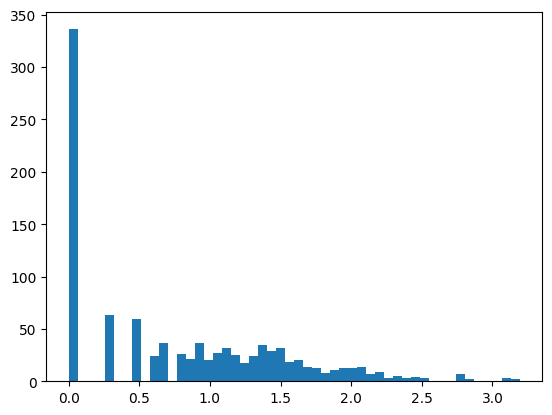

In [67]:
plt.hist(np.log(truth_table.sum(axis=1))/np.log(10),bins=50)
plt.show()

In [169]:
strength = 1-truth_table.mean(axis=0)
strong_to_weak_order = sorted(range(len(starting_equations)),key=lambda i: -strength[i])
focus_subset = set([x-1 for x in [1,2,3,4,5,6,7,8,38,39,40,41,42,43,45,46,168,387,4522,4513,4512,4582]])
strong_to_weak_order = [x for x in strong_to_weak_order if x in focus_subset]

In [170]:
implications = []
cluster_lookup = {} #representative to list of members
parent_lookup = defaultdict(list) #rep to parent reps
upstream_cache = {}
def all_upstream(rep):
    if rep not in upstream_cache:
        output = set([rep])
        for p in parent_lookup[rep]:
            output = output | all_upstream(p)
        upstream_cache[rep] = output
    return upstream_cache[rep]
frontier = set()

for swi,equation_index in enumerate(strong_to_weak_order):
    upstream_order = strong_to_weak_order[:swi][::-1]
    upstream_order = [x for x in upstream_order if x in cluster_lookup]
    seen = {i:False for i in upstream_order} #do we know we don't have to check for implication from this guy?
    equivalence_found = False
    for rep in upstream_order:
        if not seen[rep]:
            if strength[rep]==strength[equation_index]: #might be equivalent
                if np.all(truth_table[:,equation_index]==truth_table[:,rep]):
                    cluster_lookup[rep].append(equation_index)
                    equivalence_found = True
                    break
            #now things that might be strict implications
            if strength[rep] > strength[equation_index]:
                if np.all(truth_table[:,equation_index] >=truth_table[:,rep]):
                    implications.append([rep,equation_index])
                    parent_lookup[equation_index].append(rep)
                    for up in all_upstream(rep):
                        seen[up]=True
                    
    if not equivalence_found:
        #create a new cluster
        cluster_lookup[equation_index] = [equation_index]




In [171]:
sorted_strengths = sorted(set(strength[list(focus_subset)]))[::-1]
strength_to_index = {sorted_strengths[i]:i for i in range(len(sorted_strengths))}

In [172]:
cluster_lookup

{1: [1, 5, 6, 167],
 4: [4],
 40: [40, 45, 4581],
 3: [3],
 386: [386],
 4512: [4512, 4521],
 38: [38, 44],
 37: [37, 41],
 4511: [4511],
 2: [2],
 42: [42],
 39: [39],
 7: [7],
 0: [0]}

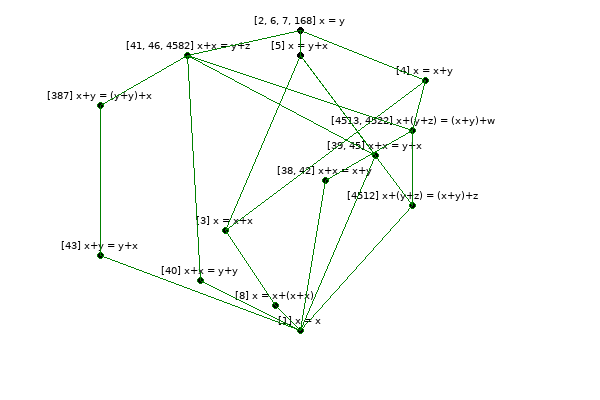

In [173]:
img = blank_image(400,600)
d = Draw(img)
d.shift(0,170)

loc_lookup = {}

known_offset = {
    1: 0,
    3: 0.5,
    4: 0,
    167: 0.8,
    37: 0.1,
    38: 0.3,
    4521: 0.45,
    4512: 0.45,
    4511: 0.45,
    2: -0.3,
    7: -0.1,
    386: -0.8,
    42: -0.8,
    40: -0.45,
    4581: -0.4,
    39: -0.4,
    0: 0,
}

for rep,value in cluster_lookup.items():
    weakness_index = strength_to_index[strength[rep]]
    equation = starting_equations[rep]
    loc = (known_offset.get(rep,random.random()*2-1)*250,-25*weakness_index)
    loc_lookup[rep] = loc
    d.circle(loc,r=3,fill='black')
    d.text(xy=(loc[0],loc[1]+10),text=f"{[x+1 for x in value]} {equation}",font_size=10,color='black')
    for P in parent_lookup[rep]:
        d.line(loc_lookup[P],loc_lookup[rep],color='green')
        
img

In [ ]:
falsify_implication()

In [98]:
[r for r in cluster_lookup if strength_to_index[strength[r]]==1]

[3, 1488]

In [104]:
def falsify_implication(a,b):
    mis = [i for i in range(len(starting_magmas)) if truth_table[i][a] and not truth_table[i][b]]
    assert len(mis)>=1, f"actually {a} -> {b} is true!"
    return starting_magmas[mis[0]]

In [107]:
M = falsify_implication(1488,1)
M.table

[[0, 1, 1], [2, 1, 2], [0, 0, 2]]

In [109]:
Equation.from_string("x=(y+x)+(y+(x+y))").is_tautology_on(M)

True

In [103]:
starting_equations[1488]

x = (y+x)+(y+(x+y))

In [101]:
[i for i,E in enumerate(starting_equations) if str(E)=='x = y+x']

[4]

In [102]:
strength[4]

0.9980314960629921

In [99]:
strength[3]

0.9990157480314961

In [95]:
len(sorted_strengths)

107

In [86]:
starting_equations[random.choice(cluster_lookup[3])]

x = x+(((y+z)+z)+z)

In [88]:
{x:len(cluster_lookup[x]) for x in cluster_lookup}

{1: 1552,
 3: 212,
 1488: 1,
 4: 159,
 13: 121,
 40: 511,
 55: 1,
 62: 5,
 622: 2,
 1020: 1,
 1481: 6,
 48: 31,
 52: 2,
 64: 29,
 282: 2,
 313: 18,
 365: 24,
 373: 72,
 463: 1,
 614: 1,
 2037: 12,
 4389: 3,
 12: 152,
 27: 27,
 49: 1,
 54: 5,
 105: 16,
 223: 9,
 316: 6,
 335: 57,
 361: 7,
 451: 8,
 476: 34,
 1478: 2,
 3472: 4,
 3878: 4,
 4380: 2,
 4498: 1,
 4588: 39,
 259: 2,
 317: 5,
 342: 1,
 415: 12,
 730: 14,
 1025: 1,
 1072: 18,
 1239: 1,
 2040: 2,
 2063: 3,
 2295: 1,
 2305: 7,
 2648: 1,
 2664: 1,
 3384: 26,
 3565: 2,
 3735: 5,
 3754: 5,
 3862: 3,
 4390: 3,
 4394: 1,
 4497: 1,
 4594: 5,
 23: 151,
 74: 1,
 110: 8,
 241: 20,
 331: 9,
 364: 12,
 619: 1,
 642: 1,
 668: 2,
 837: 1,
 1693: 6,
 2039: 2,
 2849: 2,
 2861: 1,
 2898: 1,
 3349: 12,
 3470: 2,
 3494: 1,
 3717: 2,
 3736: 4,
 3789: 2,
 3822: 1,
 4273: 39,
 4381: 2,
 4419: 1,
 4482: 1,
 99: 12,
 137: 13,
 159: 37,
 220: 6,
 312: 9,
 314: 1,
 416: 1,
 436: 2,
 616: 1,
 618: 1,
 715: 3,
 1085: 8,
 1640: 1,
 1723: 1,
 1930: 2,
 2302: 

In [89]:
len(cluster_lookup)

706

In [76]:
implications

[[1, 3],
 [1, 1488],
 [1, 4],
 [1, 13],
 [1, 40],
 [3, 55],
 [1, 62],
 [3, 622],
 [3, 1020],
 [1, 1481],
 [4, 48],
 [3, 48],
 [62, 52],
 [3, 52],
 [4, 64],
 [4, 282],
 [40, 313],
 [40, 365],
 [40, 373],
 [3, 373],
 [13, 463],
 [1020, 614],
 [622, 614],
 [13, 2037],
 [3, 2037],
 [40, 4389],
 [4, 12],
 [64, 27],
 [1488, 27],
 [52, 49],
 [622, 49],
 [64, 54],
 [48, 54],
 [3, 105],
 [4, 223],
 [313, 316],
 [40, 335],
 [4, 335],
 [373, 361],
 [365, 361],
 [2037, 451],
 [13, 476],
 [1481, 1478],
 [13, 1478],
 [4389, 3472],
 [313, 3472],
 [4389, 3878],
 [365, 3878],
 [4389, 4380],
 [373, 4380],
 [4389, 4498],
 [365, 4588],
 [54, 259],
 [27, 259],
 [335, 317],
 [313, 317],
 [335, 342],
 [12, 415],
 [48, 415],
 [13, 730],
 [4, 730],
 [451, 1025],
 [463, 1072],
 [62, 1072],
 [105, 1239],
 [2037, 2040],
 [476, 2063],
 [2037, 2063],
 [223, 2295],
 [282, 2295],
 [223, 2305],
 [54, 2648],
 [223, 2664],
 [48, 2664],
 [40, 3384],
 [13, 3384],
 [335, 3565],
 [64, 3565],
 [335, 3735],
 [373, 3735],
 [48

In [57]:
len(starting_equations)

4694

In [70]:
def equation_implies(i,j):
    return np.all(truth_table[:,i]<=truth_table[:,j])
def equivalent(i,j):
    return equation_implies(i,j) and equation_implies(j,i)
def direct_implies(i,j):
    if not equation_implies(i,j):
        return False
    for k in range(len(starting_equations)):
        if k!=i and k!=j and (equation_implies(i,k) and equation_implies(k,j)):
            return False
    return True

In [170]:
for i,j in itertools.product(*[range(len(starting_equations))]*2):
    if strength[i]>strength[j]>0:
        if direct_implies(i,j):
            print(f"{starting_equations[i]} -> {starting_equations[j]}")
for i,j in itertools.product(*[range(len(starting_equations))]*2):
    if i!=j and strength[i]==strength[j]>0 and equivalent(i,j):
        print(f"{starting_equations[i]} == {starting_equations[j]}")

x = x+x -> x = x+(x+x)
x = x+y -> x = x+x
x = y+x -> x = x+x
x = y+x -> x+x = y+x
x+x = y+z -> x+x = y+x
x+x = y+z -> x+x = y+y
x+x = y+z -> x+y = y+x
x = y == x = y+y
x = y == x = y+z
x = y+y == x = y
x = y+y == x = y+z
x = y+z == x = y
x = y+z == x = y+y
x+x = x+y == x+y = x+z
x+y = x+z == x+x = x+y


In [71]:
img = blank_image(3000,200)
d = Draw(img)
d.shift(0,450)

loc_lookup = {}

for weakness_index,equation_index in enumerate(strong_to_weak_order):
    loc = (random.randint(-40,40),-0.7*weakness_index)
    loc_lookup[equation_index] = loc
    d.circle(loc,r=4,fill='black')

for i,j in itertools.product(*[range(len(starting_equations))]*2):
    if strength[i]>strength[j]:
        if direct_implies(i,j):
            d.line(loc_lookup[i],loc_lookup[j],color='green')
    elif strength[i]==strength[j]:
        if equivalent(i,j):
            d.line(loc_lookup[i],loc_lookup[j],color='blue')
img

KeyboardInterrupt: 

In [157]:
d.line?

In [130]:
d.circle?

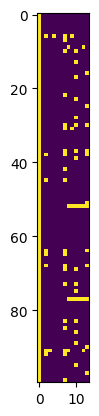

In [121]:
plt.imshow(truth_table)
plt.show()

In [112]:
equations[:40]

[x = x,
 x = y,
 x = x+x,
 x = x+y,
 x = y+x,
 x = y+y,
 x = y+z,
 x = x+(x+x),
 x = x+(x+y),
 x = x+(y+x),
 x = x+(y+y),
 x = x+(y+z),
 x = y+(x+x),
 x = y+(x+y),
 x = y+(x+z),
 x = y+(y+x),
 x = y+(y+y),
 x = y+(y+z),
 x = y+(z+x),
 x = y+(z+y),
 x = y+(z+z),
 x = y+(z+w),
 x = (x+x)+x,
 x = (x+x)+y,
 x = (x+y)+x,
 x = (x+y)+y,
 x = (x+y)+z,
 x = (y+x)+x,
 x = (y+x)+y,
 x = (y+x)+z,
 x = (y+y)+x,
 x = (y+y)+y,
 x = (y+y)+z,
 x = (y+z)+x,
 x = (y+z)+y,
 x = (y+z)+z,
 x = (y+z)+w,
 x+x = x+y,
 x+x = y+x,
 x+x = y+y]

In [104]:
len(equation_texts)

4696

In [102]:
Equation(B,B).is_tautology_on(M)

True

In [19]:
trivial_magma = Magma([[0]])


equation = Equation(Expression('x'), Expression('y'))

equation.evaluate(trivial_magma, {'x': 0, 'y': 0})

True

In [20]:
c2 = Magma([
    [0, 1],
    [1, 0],
])

equation.evaluate(c2, {'x': 0, 'y': 1})

False